# ❤️나만의 이미지 분류기 만들어보기
<br>  

## 🤖step1. 데이터셋 내려받기

In [1]:
# 데이터 불러오기
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
import numpy as np
import os
from tensorflow.keras.applications import VGG16

In [2]:
# 데이터셋 내려받기
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/tf_flowers/',
    with_info=True,
    as_supervised=True,
)



print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


---


In [3]:
# 데이터 확인을 위한 `matplotlib` 라이브러리 호출

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

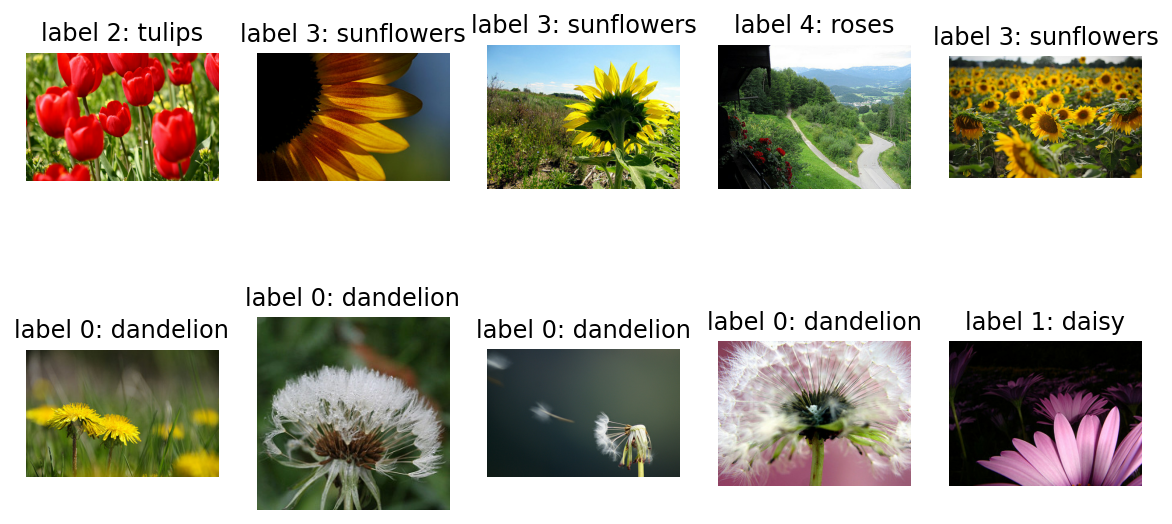

In [4]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

label0 은 민들레,  
label1 은 데이지,  
label2 는 튤립,  
label3 는 해바라기,  
label4 는 장미  
__총 5개의 클래스를 가지고 있는 것을 확인할 수 있다.__

‍🌈 간단 지식 - 타입캐스팅(Type Casting)  
형변환이라고도 불리는 타입개스팅은 다른 데이터 타입으로 형(타입)을 바꿔주는 것을 의미한다. 정수형을 실수형으로 바꾸기 위해 `float()`를 사용하는 것이 타입캐스팅의 한 예이다.  

## 🤖step2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

In [5]:
# 160x160 픽셀로 통일시킬 뿐만 아니라, 각 픽셀값의 scale을 수정해보자
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [6]:
# 데이터 증강을 적용한 format_example 함수
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
    image = tf.image.random_hue(image, max_delta=0.1)
    
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

In [7]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


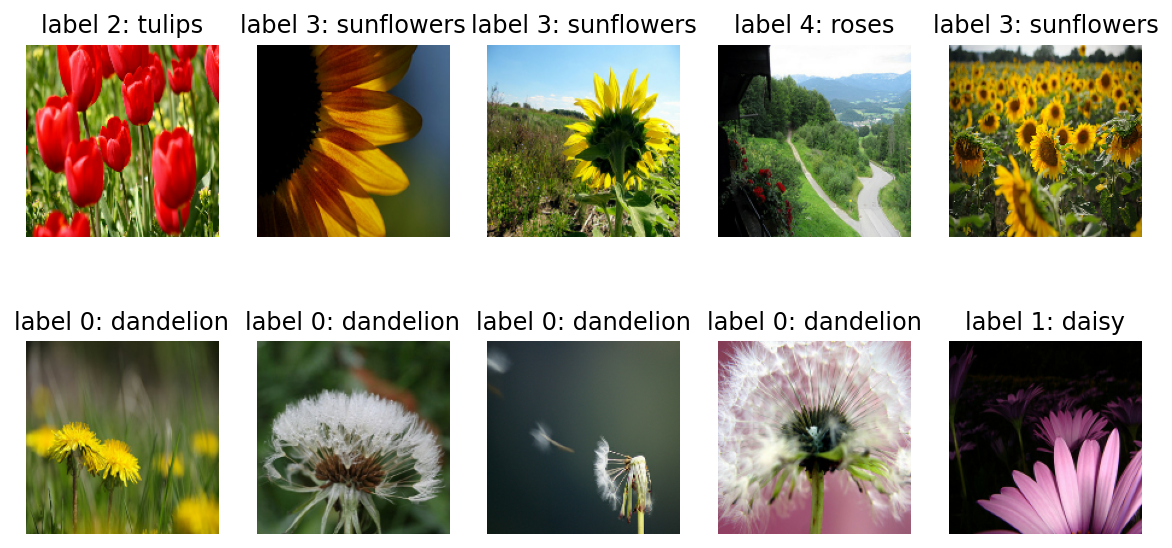

In [8]:
# 다시 시각적으로 확인해보자
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

- 이미지 사이즈가 균일해진 것을 확인 할 수 있다.

## 🤖Step 3. 모델 설계하기

In [37]:
# model = Sequential([
#     Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
#     MaxPooling2D(),
#     Dropout(0.3),
#     Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Dropout(0.3),
#     Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Flatten(),
#     BatchNormalization(),
#     Dense(units=512, activation='relu'),
#     Dense(units=5, activation='softmax') #클래스가 5개
# ])

# model.summary()

- VGG16를 base model로 가져오는게 더 좋은 결과를 가져올테니 VGG16 모델을 커스텀해보자

In [9]:
# VGG16를 base model로 만들기
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # VGG16의 기존 학습된 가중치들을 동결

# base model에 dense layers를 추가하여 커스텀하기
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')  # 5개의 클래스
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


👉 **VGG16의 기존 학습된 가중치들을 동결(Freeze)하는 역할을 한다.**   
        **output에 가까운 높은 레벨에 있는 3개의 FC 레이어는 제외하고 불러와야 하므로 `include_top=False` 옵션을 주었다.**  
    

## 🤖Step 4. 모델 학습시키기

In [38]:
# learning_rate = 0.001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#               loss=tf.keras.losses.sparse_categorical_crossentropy,
#               metrics=['accuracy'])

# 이 학습률은 별로,,,,

In [10]:
learning_rate = 0.0015
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

👉 `RMSprop`의 기본 학습률은 0.001이다. learning_rate 를 `0.0001`로 정한 이유는 초기에는 작은 학습률을 사용하여 모델을 **안정적으로 학습시키고자 했기 때문이다.**  
👉 `Adam`도 기본적으로 많이 사용하기 때문에 비교를 해보았는데 확률은 똑같이 나왔다. `Adam`이 더 친근하니 `Adam`을 사용하겠다. 😀

<BR>  
<BR>  
    <BR>  
        
---

`compile`을 하기 위해서는 세 가지가 필요합니다. 바로 `optimizer`, `loss`, `metrics` 라는 요소들이다.  

- **`optimizer`는 학습을 어떤 방식으로 시킬 것인지 결정한다.** 어떻게 최적화시킬 것인지를 결정하기 때문에 최적화 함수라고 부르기도 한다.    
- **`loss`는 모델이 학습해나가야 하는 방향을 결정한다.**   
- **`metrics`는 모델의 성능을 평가하는 척도이다.** 분류 문제를 풀 때, 성능을 평가할 수 있는 지표는 정확도(accuracy), 정밀도(precision), 재현율(recall) 등이 있다.  

In [11]:
# 스텝에 학습시킬 데이터의 개수인 BATCH_SIZE와 학습 데이터를 적절히 섞어줄 SHUFFLE_BUFFER_SIZE를 설정
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

- `BATCH_SIZE`에 따라 32개의 데이터를 랜덤으로 뿌려줄 `train_batches`, `validation_batches`, `test_batches`를 만들어 주자. `train_batches`는 모델이 끊임없이 학습될 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공해 줄 것이다.

In [12]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [13]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [14]:
validation_steps = 10
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 7s 68ms/step - loss: 1.7284 - accuracy: 0.1813
initial loss: 1.73
initial accuracy: 0.18


- `BATCH_SIZE`에 따라 32개의 데이터를 랜덤으로 뿌려줄 `train_batches`, `validation_batches`, `test_batches`를 만들어 주자. `train_batches`는 모델이 끊임없이 학습될 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공해 줄 것이다.

- 학습 전에 이 모델이 어떤 성능을 나타내는지 확인하는 정도이니, 너무 신경쓰지말자! 

In [15]:
# # 훈련 데이터셋에 대한 정확도 확인
# train_loss, train_accuracy = model.evaluate(train_batches)
# print(f'Training Accuracy: {train_accuracy:.4f}')

# # 테스트 데이터셋에 대한 정확도 확인
# test_loss, test_accuracy = model.evaluate(test_batches)
# print(f'Test Accuracy: {test_accuracy:.4f}')

In [23]:
EPOCHS = 40

# 얼리 스톱핑을 위한 콜백 추가
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 얼리 스톱핑 수행
    patience=5,           # 3 에포크 동안 검증 손실이 감소하지 않으면 학습 중단
    restore_best_weights=True  # 얼리 스톱핑 시 가장 좋았던 가중치로 복원
)
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/40
92/92 [==============================] - 8s 81ms/step - loss: 0.3315 - accuracy: 0.8753 - val_loss: 0.5101 - val_accuracy: 0.8229
Epoch 2/40
92/92 [==============================] - 8s 83ms/step - loss: 0.3128 - accuracy: 0.8852 - val_loss: 0.4408 - val_accuracy: 0.8392
Epoch 3/40
92/92 [==============================] - 8s 82ms/step - loss: 0.2948 - accuracy: 0.8931 - val_loss: 0.4631 - val_accuracy: 0.8447
Epoch 4/40
92/92 [==============================] - 8s 81ms/step - loss: 0.2760 - accuracy: 0.8965 - val_loss: 0.4718 - val_accuracy: 0.8392
Epoch 5/40
92/92 [==============================] - 8s 81ms/step - loss: 0.2530 - accuracy: 0.9063 - val_loss: 0.5046 - val_accuracy: 0.8311
Epoch 6/40
92/92 [==============================] - 8s 80ms/step - loss: 0.2460 - accuracy: 0.9097 - val_loss: 0.5501 - val_accuracy: 0.8093
Epoch 7/40
92/92 [==============================] - 8s 79ms/step - loss: 0.2384 - accuracy: 0.9121 - val_loss: 0.4537 - val_accuracy: 0.8556


- `loss`도 점점 줄고 `accuracy`의 상승세도 괜찮아 보인다.  
    단계에 따른 정확도 변화를 그래프로 확인해보자.

---

## 🤖Step 5. 모델 성능 평가하기  
<br>  
모델 학습이 완료되었다면, 모델의 성능을 평가할 차례!

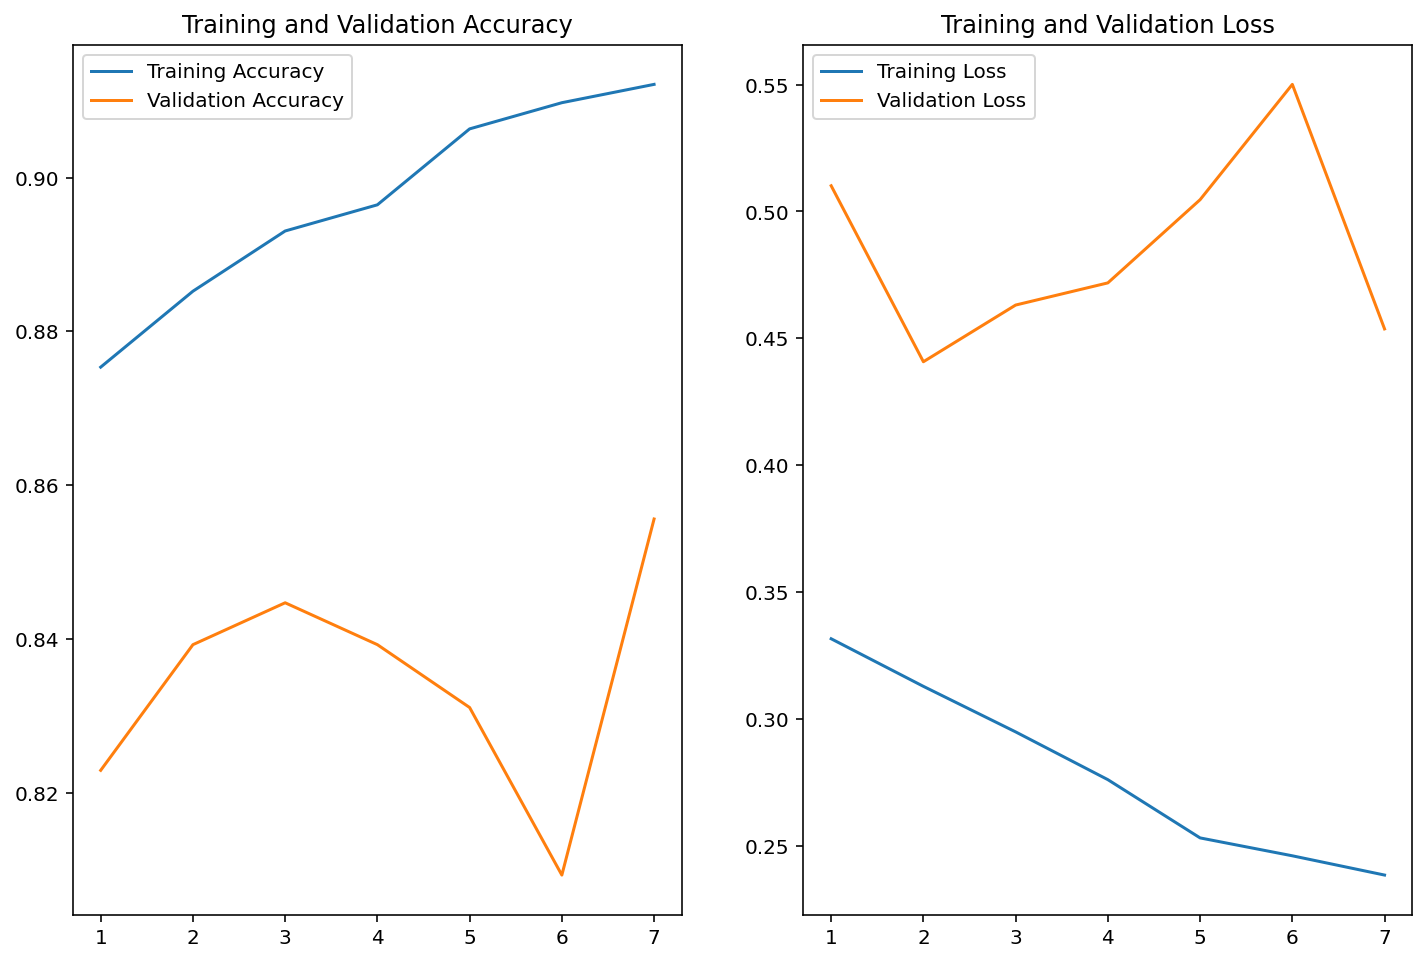

In [31]:
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


- 그래프가 튀는 것에 당황했지만 괜찮다! 

In [32]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

array([[2.39533070e-03, 9.63224377e-03, 9.60864246e-01, 1.22255273e-03,
        2.58857068e-02],
       [9.99999404e-01, 5.91401147e-07, 2.56322567e-11, 7.84558807e-11,
        2.98585467e-09],
       [5.93003392e-01, 2.47196376e-01, 1.19217522e-02, 1.42436877e-01,
        5.44164237e-03],
       [3.73675502e-05, 1.36855160e-04, 5.38724303e-01, 7.95144006e-05,
        4.61021930e-01],
       [8.05344045e-01, 1.84631839e-01, 3.50022363e-03, 2.28217244e-03,
        4.24178550e-03],
       [9.84554827e-01, 1.31432051e-02, 2.42293201e-04, 2.03196844e-03,
        2.77375020e-05],
       [2.73538608e-04, 1.26791710e-04, 9.94564891e-01, 2.43012584e-03,
        2.60461471e-03],
       [1.31211996e-01, 8.67710710e-01, 2.14488518e-05, 1.02561072e-03,
        3.02920089e-05],
       [3.27014161e-04, 2.98393752e-05, 4.44271183e-03, 9.85354781e-01,
        9.84566193e-03],
       [9.99993801e-01, 6.17666910e-06, 1.79085857e-10, 1.35583988e-09,
        4.86800322e-10],
       [9.87114787e-01, 1.2634

In [33]:
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])

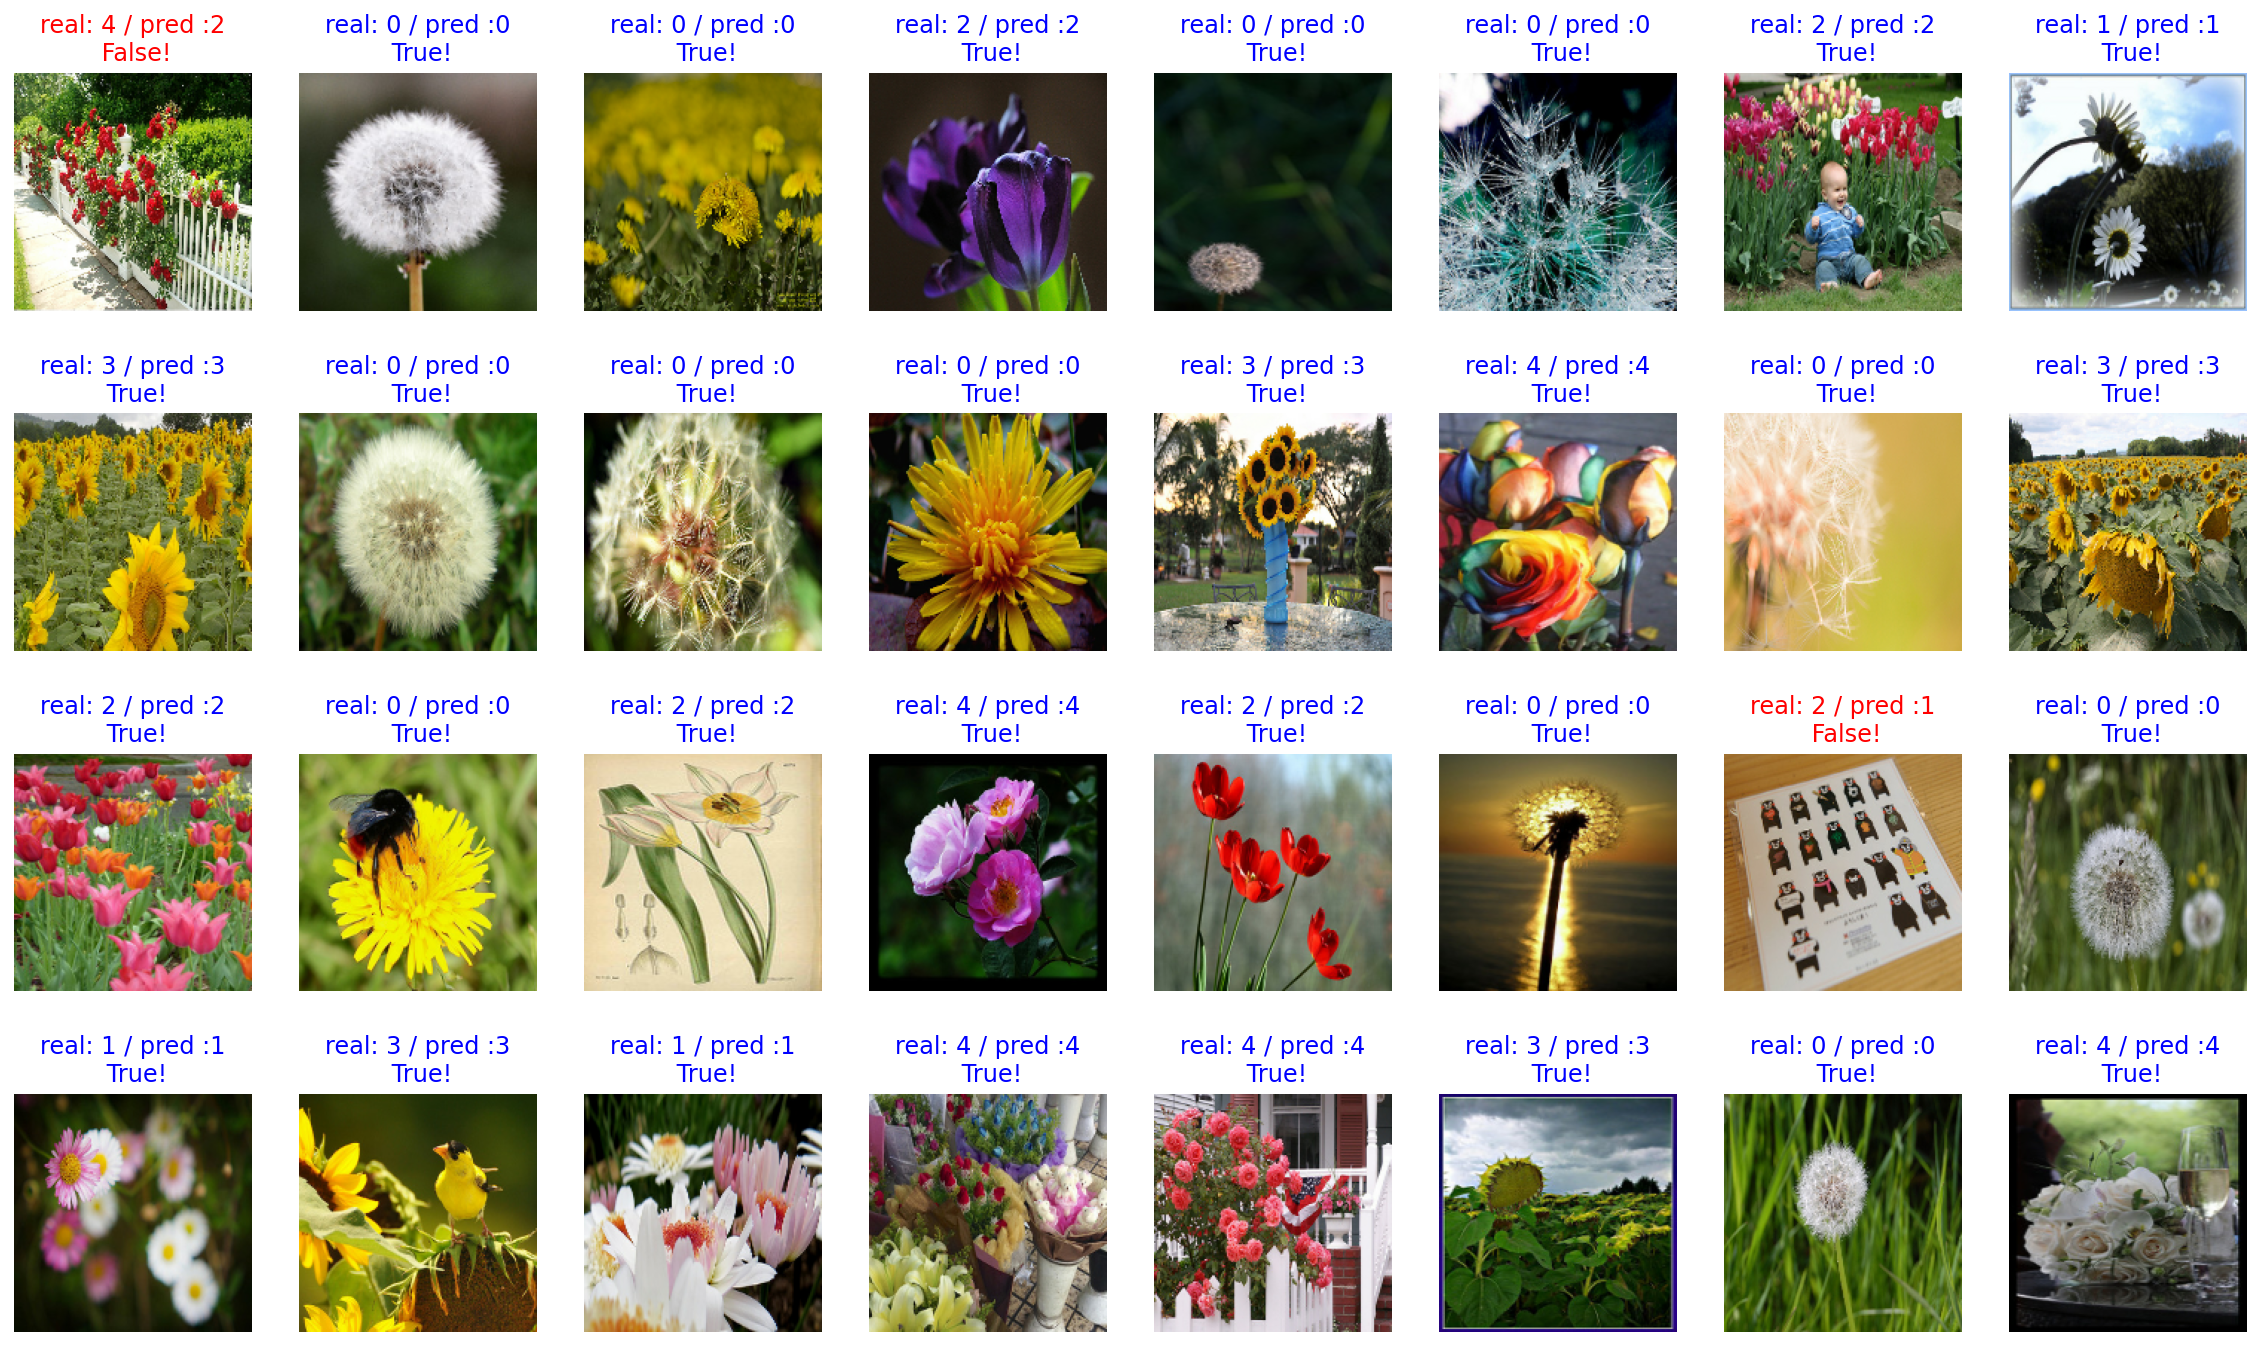

In [34]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [35]:
# 훈련 데이터셋에 대한 정확도 확인
train_loss, train_accuracy = model.evaluate(train_batches)
print(f'Training Accuracy: {train_accuracy:.4f}')

# 테스트 데이터셋에 대한 정확도 확인
test_loss, test_accuracy = model.evaluate(test_batches)
print(f'Test Accuracy: {test_accuracy:.4f}')

92/92 [==============================] - 7s 72ms/step - loss: 0.2206 - accuracy: 0.9254
Training Accuracy: 0.9254
12/12 [==============================] - 1s 64ms/step - loss: 0.4026 - accuracy: 0.8556
Test Accuracy: 0.8556


**Test Accuracy 85% 이상 확인!**

In [36]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1


print(count / 32 * 100)

93.75


**93.75%의 정확도를 가지고 있다!**

---
<br>  

## 🤖Step 6. 모델 활용하기  

#### 위를 바탕으로 함수를 만들어서 원하는 사진을 모델에 넣어보자!


In [39]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulips_percentage =  round(prediction[2] * 100)
    sunflower_percentage =  round(prediction[3] * 100)
    rose_percentage = round(prediction[4] * 100)
    print(f"This image seems {dandelion_percentage}% dandelion.")
    print(f"This image seems {daisy_percentage}% daisy.")
    print(f"This image seems {tulips_percentage}% tulips.")
    print(f"This image seems {sunflower_percentage}% sunflower.")
    print(f"This image seems {rose_percentage}% rose.")

In [40]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1


print(count / 32 * 100)

93.75


This image seems 0% dandelion.
This image seems 0% daisy.
This image seems 0% tulips.
This image seems 0% sunflower.
This image seems 100% rose.


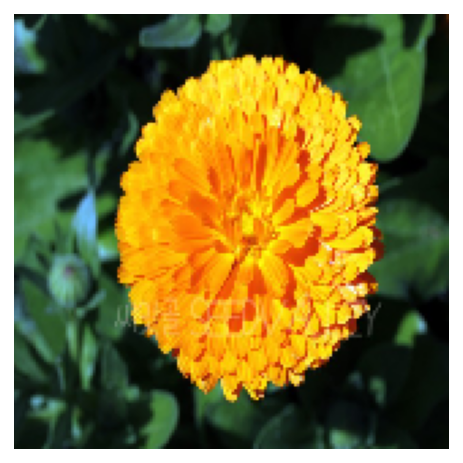

In [44]:
img_dir_path = os.getenv("HOME") + "/aiffel/tf_flowers"
filename = "goldflower.jpg"
show_and_predict_image(img_dir_path, filename)

- 틀리는 경우도 당연히 있다 😀

This image seems 0% dandelion.
This image seems 0% daisy.
This image seems 100% tulips.
This image seems 0% sunflower.
This image seems 0% rose.


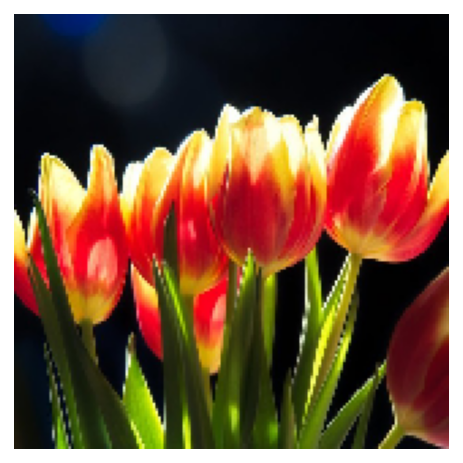

In [42]:
img_dir_path = os.getenv("HOME") + "/aiffel/tf_flowers"
filename = "tulips2.jpg"
show_and_predict_image(img_dir_path, filename)

This image seems 0% dandelion.
This image seems 0% daisy.
This image seems 0% tulips.
This image seems 0% sunflower.
This image seems 100% rose.


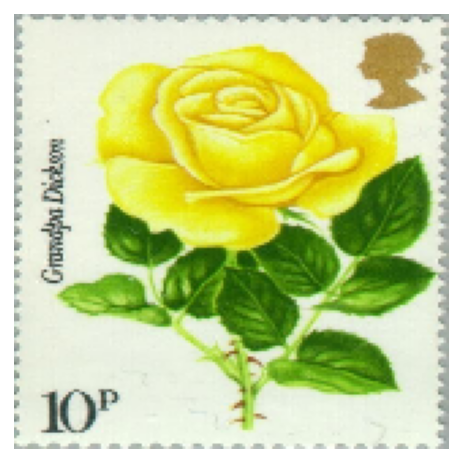

In [43]:
img_dir_path = os.getenv("HOME") + "/aiffel/tf_flowers"
filename = "rose_stamp.jpg"
show_and_predict_image(img_dir_path, filename)

<br>  
<br>  
<br>  

---

## 🔶회고  
<br>  

### - **Keep**:    

    앞서 노드학습으로 진행했던 코드를 잘 활용하고 중간 중간 이해가 안되는 하이퍼 파라미터들의 뜻들을 찾아보며 평소와 같이 구글링을 열심히 했다.     
    <br> 
    
### - **Problem**:  

    찍어 맞춘 부분들이 있어 좀 아쉽다.     
    <br>  
    
### - **Try**:  

    찍어 맞춘 부분들에 관한 구글링을 해봐도 깔끔하게 해결되지 않는 의문들.. 더 열심히 찾아보자.